# TileDB-SOMA: Spatial transciptomics support

## Overview

This notebook demonstrates how to use TileDB-SOMA to store and query spatial transcriptomics data. You will:

- Download sample data from https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma
- Ingest into a SOMA spatial experiment
- Access and visualize spatial data

**WARNING** _Spatial support is experimental and under active development. There will likely be breaking changes to both the storage format and API._

## Setup

Import `tiledbsoma` and other necessary libraries.

In [1]:
from functools import partial
from shutil import rmtree
from sys import stderr

import numpy as np
from matplotlib import patches as mplp
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from PIL import Image

err = partial(print, file=stderr)

from pathlib import Path

import scanpy as sc
from scanpy.datasets._datasets import (
    _download_visium_dataset as download_visium_dataset,
)

import tiledbsoma
import tiledbsoma.experimental
import tiledbsoma.io

Define variables used throughout the notebook.

In [2]:
# 10X Example dataset
DATASET_NAME = "CytAssist_FFPE_Protein_Expression_Human_Glioblastoma"
SPACERANGER_VERSION = "2.1.0"

# SOMA experiment destination
DATA_DIR = Path("data")
DATASET_DIR = DATA_DIR / DATASET_NAME
SOMA_URI = DATA_DIR / "soma"

# SOMA experiment parameters
MEASUREMENT_NAME = "RNA"  # Dataset modality name
SCENE_NAME = "scene0"  # Name of scene where spatial data is stored

### Download sample data from 10x
This section will download data from 10x and use that data to generate the TileDB-SOMA `Experiment` with spatial data.

In [3]:
download_visium_dataset(
    sample_id=DATASET_NAME, spaceranger_version=SPACERANGER_VERSION, base_dir=DATA_DIR
)

## Ingestion

Here we ingest the 10X Visium data into a SOMA `Experiment` object. The diagram below shows how the data maps from the Space Ranger output to SOMA's spatial data model (non-spatial elements are excluded for clarity).

```mermaid
flowchart LR
    style SpaceRanger fill:#e6f7ff,stroke:#3399ff,stroke-width:2px,font-family:Arial,font-size:14px
    style tissue_positions_csv fill:#ffffff,stroke:#80bfff,stroke-width:2px,font-family:Arial,font-size:13px
    style down_sampled_images fill:#ffffff,stroke:#80bfff,stroke-width:2px,font-family:Arial,font-size:13px
    
    style SOMAExperiment fill:#e8ffe6,stroke:#33cc33,stroke-width:2px,font-family:Arial,font-size:14px
    style spatial fill:#f6fff6,stroke:#66cc66,stroke-width:2px,font-family:Arial,font-size:13px
    style scene fill:#ffffff,stroke:#99ff99,stroke-width:2px,font-family:Arial,font-size:12px
    style img fill:#ffffff,stroke:#ccffcc,stroke-width:2px,font-family:Arial,font-size:12px
    style obsl fill:#ffffff,stroke:#ccffcc,stroke-width:2px,font-family:Arial,font-size:12px

    subgraph SpaceRanger
      json_scale_factors["scale_factors_json: json"]
      subgraph tissue_positions_csv["tissue_positions.csv: csv"]
        csv_in_tissue["in_tissue"]
        csv_array_row["array_row"]
        csv_array_col["array_col"]
        csv_pxl_row["pxl_row_in_fullres"]
        csv_pxl_col["pxl_col_in_fullres"]
      end
      subgraph down_sampled_images["Down-sampled Images"]
        hires_image["tissue_hires_image.png"]
        lowres_image["tissue_lowres_image.png"]
      end
    end

    subgraph SOMAExperiment
      subgraph spatial["spatial: Collection"]
        subgraph scene["soma_scene_0: SOMAScene"]
          scene_meta["collection metadata"]
          subgraph img["img: Collection"]
            subgraph input_img["tissue: Image2DCollection"]
                hires_soma["hires_image: SOMADenseSpatialArray[cyz]"]
                lowres_soma["lowres_image: SOMADenseSpatialArray[cyz]"]
            end
          end
          subgraph obsl["obsl: Collection"]
            loc["loc: GeometryDataFrame"]
          end
        end
      end
    end

    json_scale_factors--metadata-->scene_meta
    json_scale_factors-->loc
    
    hires_image-->hires_soma
    lowres_image-->lowres_soma

    tissue_positions_csv-->loc
```

In [4]:
if SOMA_URI.exists():
    print(f"Deleting existing SOMA experiment at {SOMA_URI}")
    rmtree(SOMA_URI)

tiledbsoma.experimental.from_visium(
    experiment_uri=SOMA_URI.as_posix(),
    input_path=DATASET_DIR.as_posix(),
    measurement_name=MEASUREMENT_NAME,
    scene_name=SCENE_NAME,
    use_raw_counts=False,
)

Deleting existing SOMA experiment at data/soma


/Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



'data/soma'

Examine the new SOMA `Experiment`'s on-disk structure.

In [5]:
!tree -I "_*" {SOMA_URI}

data/soma
├── ms
│   └── RNA
│       ├── X
│       │   └── data
│       └── var
├── obs
└── spatial
    └── scene0
        ├── img
        │   └── tissue
        │       ├── hires
        │       └── lowres
        ├── obsl
        │   └── loc
        └── varl

16 directories, 0 files


## Data access

Spatial SOMA experiments can be accessed and queried using any of `tiledbsoma`'s existing APIs.

In [6]:
exp = tiledbsoma.Experiment.open(SOMA_URI.as_posix())
exp

<Experiment 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma' (open for 'r') (3 items)
    'ms': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/ms' (unopened)
    'obs': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/obs' (unopened)
    'spatial': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial' (unopened)>

Here, we're loading the non-spatial elements into memory as a standard `AnnData` object.

In [7]:
adata = tiledbsoma.io.to_anndata(
    experiment=exp,
    measurement_name=MEASUREMENT_NAME,
    X_layer_name="data",
)

adata

/Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 5756 × 18085
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'

Let's visualize the most highly expressed genes in the dataset.

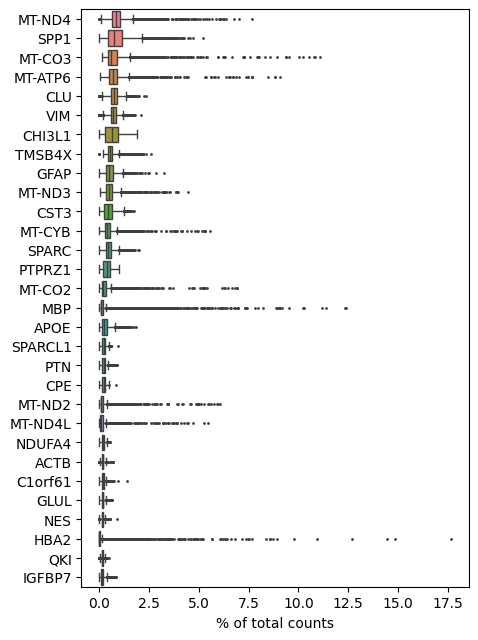

In [8]:
sc.pl.highest_expr_genes(adata)

## Spatial components

The new SOMA `Experiment` contains spatial data for this experiment stored in the `spatial` property of the Experiment. If we view the `spatial` collection we there is only one `Scene` named `scene0`.

In [9]:
scene = exp.spatial[SCENE_NAME]
scene

<Scene 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0' (open for 'r') (3 items)
    'img': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/img' (unopened)
    'obsl': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/obsl' (unopened)
    'varl': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/varl' (unopened)>


The scene contains three folders:
* `img` - A SOMA `Collection` that stores imagery data. In this example it contains an image pyramid for the high- and low-resolution slide.
* `obsl` - A SOMA `Collection` storing location data in the form of `SOMADataFrames` defined on the `obs` `somajoinid` (or `obs_id`). In this example, this contains a single dataframe with basic information about the Visium spot locations and sizes.
* `varl` - A collection that stores location data in form form of dataframes defined on the `var` `somajoinid` (or `var_id`). This collection is nested with the first layer mapping from measurement name to a collection storing dataframes. There is no feature spatial data in the Visium example, so this collection is empty.

Inside the `img` collection, there is a `Image2DCollection` storing the slide images. Here we view basic information about the slide zoom levels and read the data in the `hires` image.

In [10]:
tissue_image = scene.img["tissue"]
tissue_image

<Image2DCollection 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/img/tissue' (open for 'r') (2 items)
    'hires': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/img/tissue/hires' (unopened)
    'lowres': 'file:///Users/aaronwolen/Library/CloudStorage/Dropbox-TileDB/Aaron Wolen/customers/czi/TileDB-SOMA2/apis/python/notebooks/data/soma/spatial/scene0/img/tissue/lowres' (unopened)>

Use the `level_count` property to get the number of levels in the `Image2DCollection`.

In [11]:
tissue_image.level_count

2

Examine the metadata for each image level in the `"tissue"` collection.

In [12]:
for level in range(tissue_image.level_count):
    print(f"Level {level}: {tissue_image.level_properties(level)}")

Level 0: Image2DCollection.LevelProperties(name='soma_level_hires', axis_order='YXC', shape=[2000, 1744, 3], width=1744, height=2000, nchannels=None)
Level 1: Image2DCollection.LevelProperties(name='soma_level_lowres', axis_order='YXC', shape=[600, 523, 3], width=523, height=600, nchannels=None)


Each image is stored as a `SOMANDDenseArray` with dimensions corresponding to the image's width, height, and channels.

In [13]:
tissue_image["hires"].schema

soma_dim_0: int64 not null
soma_dim_1: int64 not null
soma_dim_2: int64 not null
soma_data: uint8 not null

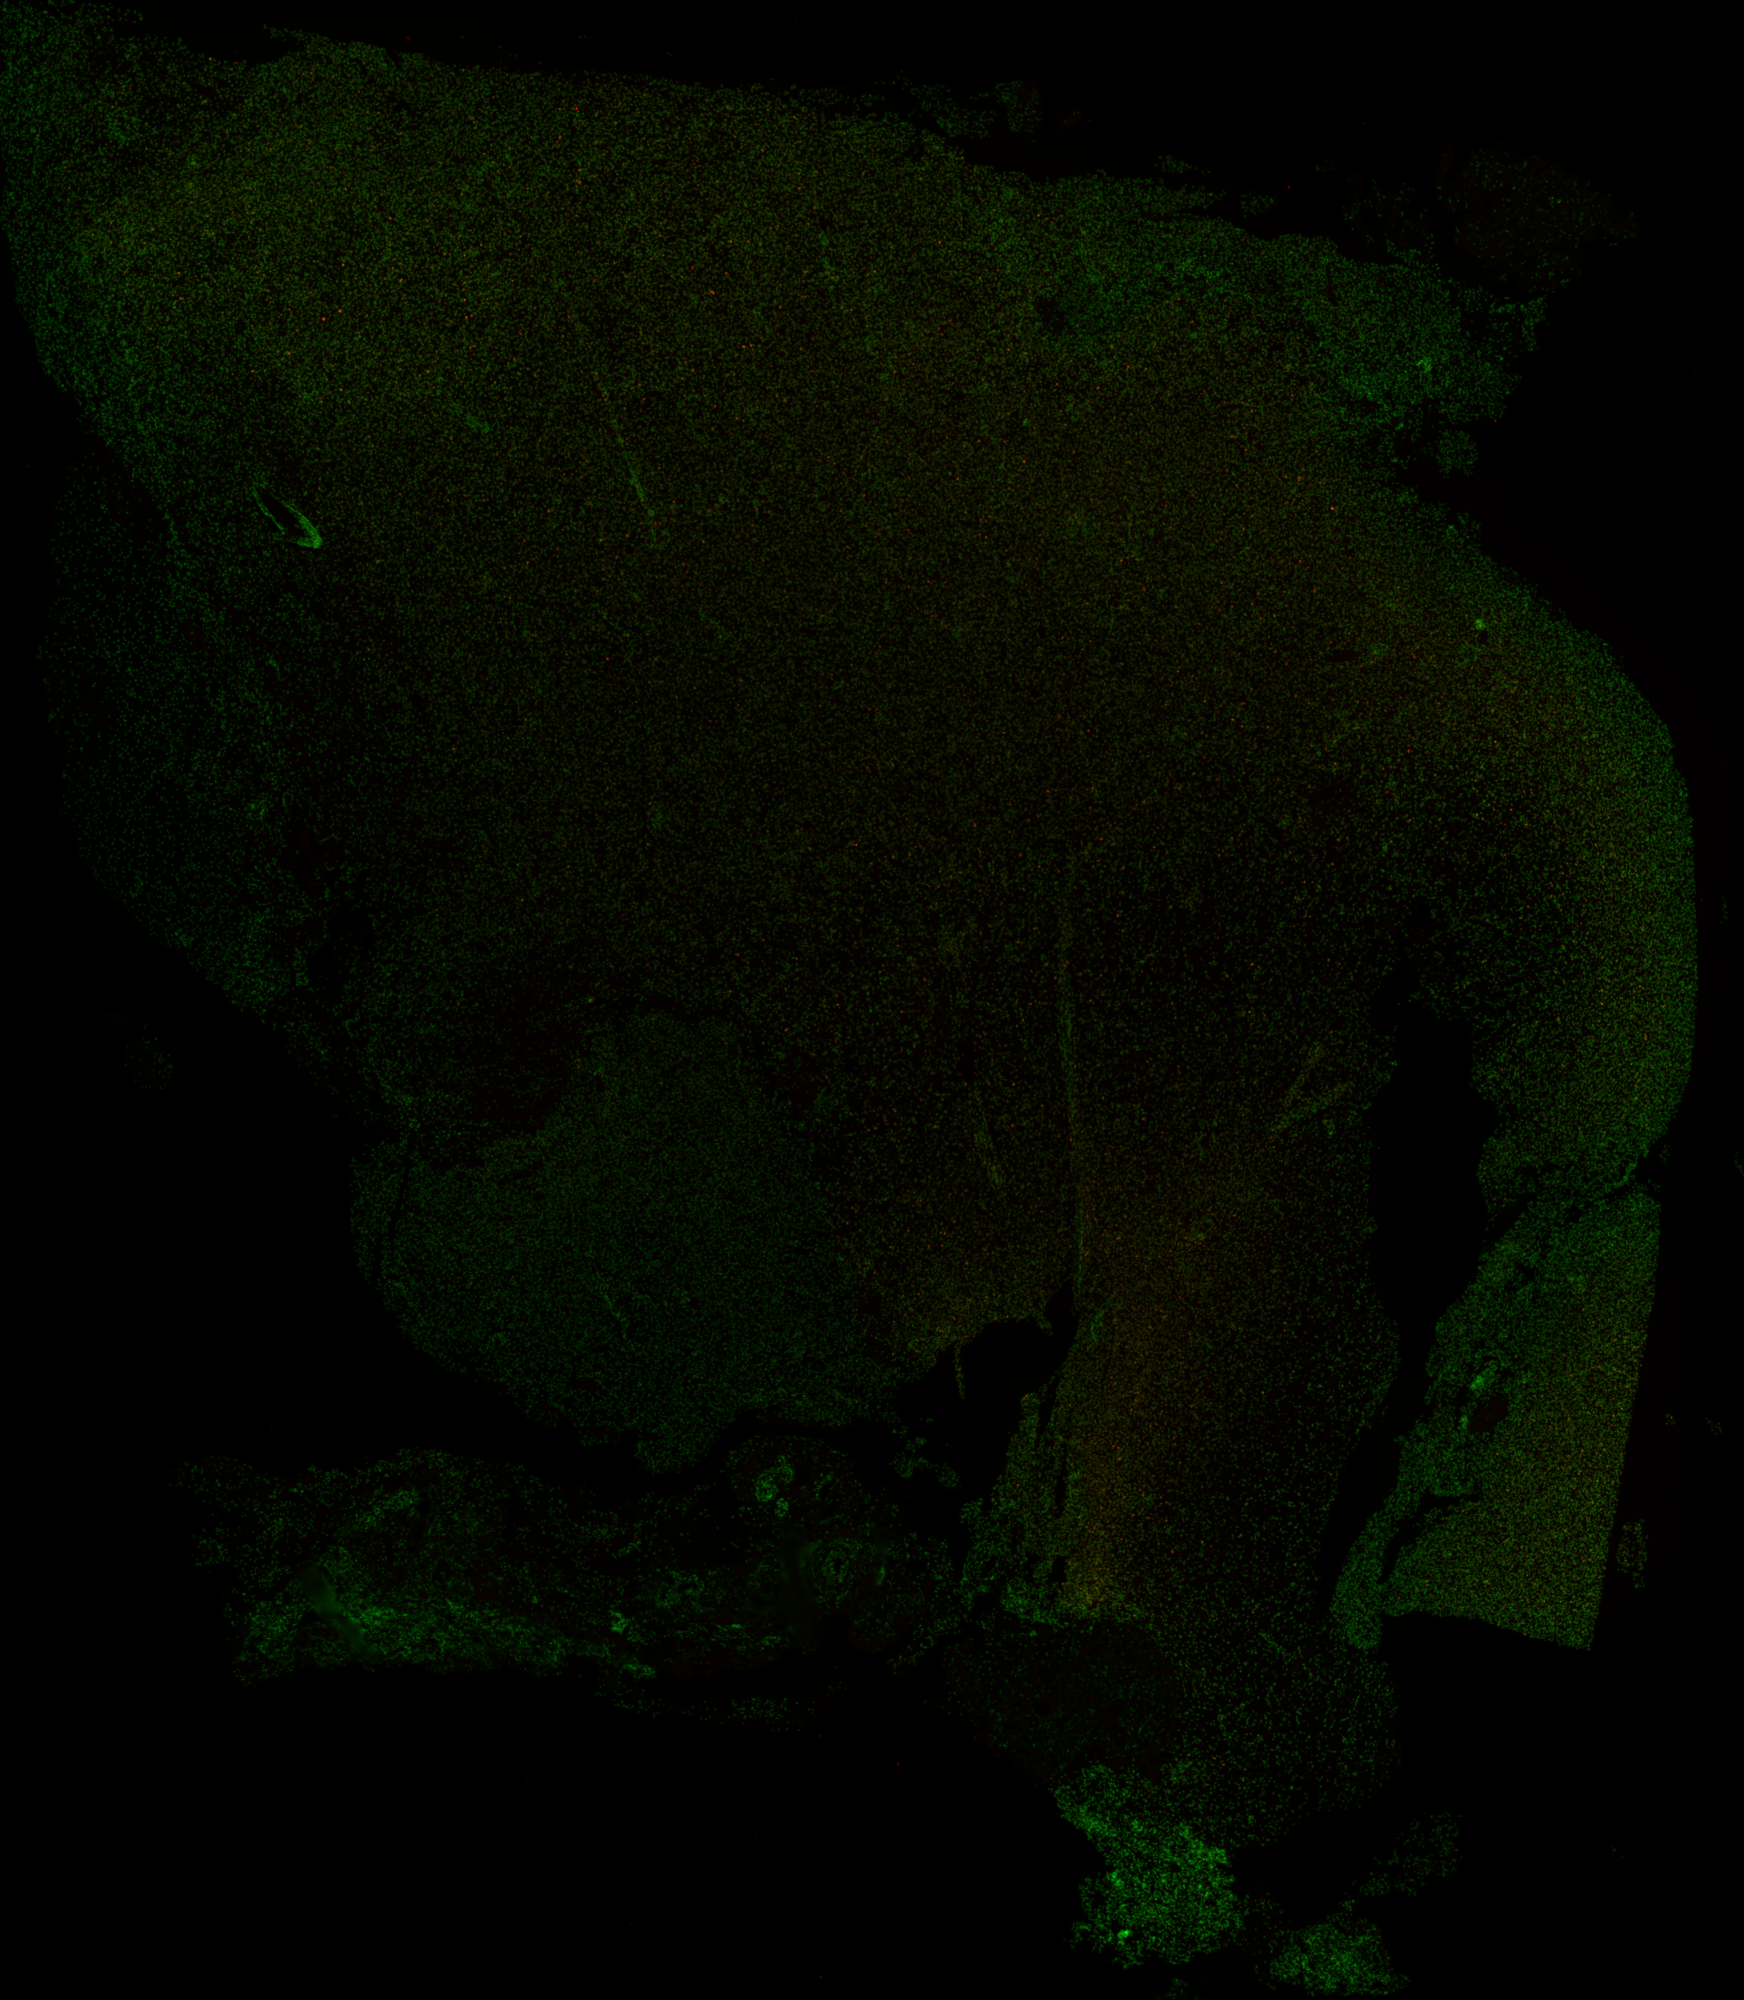

In [14]:
im = tissue_image["hires"].read().to_numpy()
Image.fromarray(im)

The `obsl` collection stores spot location data in the `loc` dataframe, which is keyed by `soma_joinid` that maps to the `obs` array in the root of the SOMA experiment.

In [15]:
spots = scene.obsl["loc"].read().concat().to_pandas()
spots

soma_joinid      x      y  in_tissue  array_row  array_col  \
0             106   1874   1174          1         19        169   
1             111   1703    379          1         16        170   
2             137    176    943          1         18        180   
3             166    165    411          1         16        180   
4             397    654   1732          1         21        177   
...           ...    ...    ...        ...        ...        ...   
5751         4115  22616  22038          1         99         37   
5752         5016  23231  22026          1         99         33   
5753         5220  22913  21500          1         97         35   
5754         5437  22594  20974          1         95         37   
5755         4910  22627  22570          1        101         37   

      _soma_geometry  
0          92.296927  
1          92.296927  
2          92.296927  
3          92.296927  
4          92.296927  
...              ...  
5751       92.296927  
5752       92.296927  
5753       92.296927  
5754       92.296927  
5755       92.296927  

[5756 rows x 7 columns]

Here we take data from the `spots` data frame, convert it to the `hires` resolution, and plot the two images together.

In [16]:
# TODO: Replace this with direct coordinate transforms
scale = (
    tissue_image.level_properties(0).height / tissue_image.metadata["fullres_height"]
)

scale

0.070916956244238

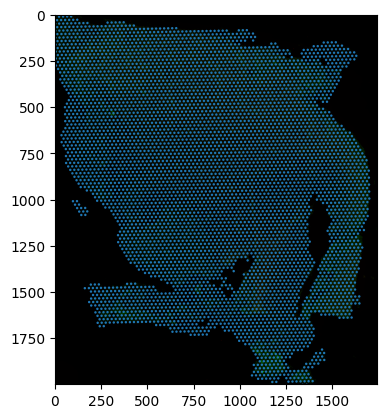

In [17]:
spot_patches = PatchCollection(
    [
        mplp.Circle(
            (scale * row["x"], scale * row["y"]),
            radius=row["_soma_geometry"] * scale,
            fill=False,
            alpha=0,
        )
        for _, row in spots.iterrows()
    ]
)

fig, ax = plt.subplots()
ax.imshow(im.astype(np.uint8))
ax.add_collection(spot_patches)

plt.show()

## Spatial visualization

Here we write a function that takes a SOMA experiment URI as input and plots spatial expression data for a gene of interest on a specific image level.

In [18]:
def plot_spatial_gene_exp(
    experiment_uri: str,
    measurement_name: str,
    scene_name: str,
    image_name: str,
    gene_symbol: str,
):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.collections import PatchCollection

    import tiledbsoma

    with tiledbsoma.Experiment.open(experiment_uri) as exp:

        # Retrieve spatial components
        scene = exp.spatial[scene_name]
        tissue_image = scene.img[image_name]
        scale = (
            tissue_image.level_properties(0).height
            / tissue_image.metadata["fullres_height"]
        )
        spots = scene.obsl["loc"].read().concat().to_pandas()

        # Retrieve gene expression
        with exp.axis_query(
            measurement_name=measurement_name,
            var_query=tiledbsoma.AxisQuery(value_filter=f"var_id == '{gene_symbol}'"),
        ) as query:
            df_exp = query.X(layer_name="data").tables().concat().to_pandas()

    # Join the gene expression data with the spots
    spots = spots.set_index("soma_joinid").join(df_exp.set_index("soma_dim_0"))

    # Normalize the attribute values to [0, 1] range (optional)
    norm = mpl.colors.Normalize(
        vmin=spots["soma_data"].min(), vmax=spots["soma_data"].max()
    )

    # Create a collection of patches for the spots
    spot_patches = PatchCollection(
        [
            mplp.Circle(
                (scale * row["x"], scale * row["y"]),
                radius=row["_soma_geometry"] * scale,
                fill=False,
                alpha=0,
            )
            for _, row in spots.iterrows()
        ]
    )

    # Choose a colormap (e.g., 'viridis')
    cmap = plt.cm.viridis

    # Map normalized attribute values to colors
    colors = cmap(norm(spots["soma_data"]))
    spot_patches.set_facecolor(colors)
    spot_patches.set_edgecolor(colors)

    # Plot the image and add the colored spots
    fig, ax = plt.subplots()
    ax.imshow(im.astype(np.uint8))
    ax.add_collection(spot_patches)

    plt.show()

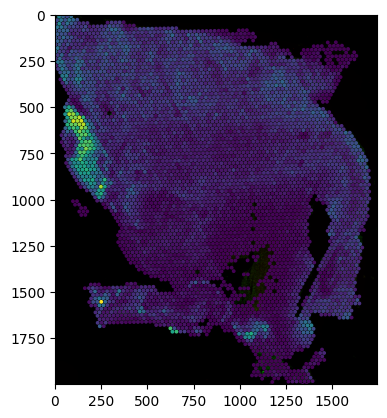

In [19]:
plot_spatial_gene_exp(
    SOMA_URI.as_posix(),
    measurement_name=MEASUREMENT_NAME,
    scene_name=SCENE_NAME,
    image_name="tissue",
    gene_symbol="MBP",
)